# Categorical Boost
#### cv score :  0.5639017013232513 (5 folds, LB 0.5609)
#### cv score :  0.5639017013232513 (5 folds, find rare, LB )
#### cv score :  0.571281663516068 ... (LB 0.555) onehotなし、

In [1]:
import sys
sys.path.append('../')
import pandas as pd
import numpy as np
import sklearn
from Functions import prepro
import warnings
warnings.filterwarnings('ignore')

import random

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
warnings.filterwarnings('ignore')
from catboost import Pool, CatBoostClassifier, CatBoost
import matplotlib.pyplot as plt
import seaborn as sns


FEATURE_SELECTION = False
tgt_encode = False

random.seed(0)

pd.set_option("display.max_columns", 1000)
pd.set_option("display.max_rows", 1000)

%matplotlib inline

In [2]:
train_df = pd.read_csv("../../data/Processed/train2.csv")
test_df = pd.read_csv("../../data/Processed/test2.csv")
print(train_df.shape)
print(test_df.shape)

(66125, 304)
(28340, 303)


In [3]:
y = train_df["y"].values
train_df = train_df.drop("y", axis=1)

In [4]:
# add disconnection info

train_df = prepro.add_disconnection(train_df)
test_df = prepro.add_disconnection(test_df)

In [5]:
# add info about numeric column
# 武器データの中のnum_colsを持つ特徴について、チーム内の統計量を計算、levelは結構効いてる

# num_cols = ["level", "range", "rapid", "atack", "ink-sub", "fav-main", "good-special"]

num_cols = [
    "level", "range-main", "range-bullet-main", "distant-range_sub", 
    "rapid", "atack", "ink-sub", "fav-main", "good-special", "DPS", "kill_time_ika-main",
    "front_gap_human-main", "rensya_frame-main", "saidai_damege-main", "damage_min-sub", 
    "damage_max-sub", "install_num-sub", "good-sub", "damage_max-special", 
    "duration-special", "good-special", "direct_rad-special", "distant_rad-special"
]

cols = [col for col in train_df.columns if "A1" in col or "A2" in col or "A3" in col or "A4" in col or 
        "B1" in col or "B2" in col or "B3" in col or "B4" in col]
drop_cols = []
for col1 in cols:
    f = True
    for col2 in num_cols:
        if col2 in col1:
            f = False
    if f and train_df[col1].dtype in [int, float]:
        drop_cols.append(col1)
        
train_df = train_df.drop(columns=drop_cols)
test_df = test_df.drop(columns=drop_cols)
        
    

train_df = prepro.add_numeric_info(train_df, num_cols)
test_df = prepro.add_numeric_info(test_df, num_cols)



In [6]:
#train_df

# 欠損値埋め先にやろう
欠損値がある列

rank, weapon, level ⇨　回線切れ or ナワバリ

weaponの欠損に並んでそれに関係ある列、A3, A4, B3, B4 ⇨ 回線切れ

level, weaponが消えていたら回線切れ

In [7]:
# rankの欠損値を埋める
train_df, test_df = prepro.fillna_rank(train_df, test_df)

#そのほかの欠損値を埋める
train_df, test_df = prepro.fillna(train_df, test_df)

In [8]:
print(train_df.isnull().sum().sum())
print(test_df.isnull().sum().sum())

0
0


# 特徴量エンジニアリング

In [9]:
# count reskin, by mode
print("reskin")
train_df, test_df = prepro.count_reskin(train_df, test_df)
train_df, test_df = prepro.count_reskin_by_mode(train_df, test_df)

# count mainweapon, by mode
print("mainweapon")
train_df, test_df = prepro.count_mainweapon(train_df, test_df)
train_df, test_df = prepro.count_mainweapon_by_mode(train_df, test_df)

# count subweapon, by mode
print("subweapon")
train_df, test_df = prepro.count_subweapon(train_df, test_df)
train_df, test_df = prepro.count_subweapon_by_mode(train_df, test_df)

# count special, by mode
print("special")
train_df, test_df = prepro.count_special(train_df, test_df)
train_df, test_df = prepro.count_special_by_mode(train_df, test_df)


#identify A1
train_df, test_df = prepro.identify_A1(train_df, test_df)


# 水増し, A1も統計量に含めた特徴を作る場合は水ましより先にやる
print("mizumashi")
train_df, y = prepro.mizumashi(train_df, y)

# is_nawabari
train_df, test_df = prepro.is_nawabari(train_df, test_df)

# match rank、単体で意味なし
train_df, test_df = prepro.match_rank(train_df, test_df)

# rankを二列に分ける
train_df, test_df = prepro.ranker(train_df, test_df)




reskin
mainweapon
subweapon
special
mizumashi


In [10]:
# add team info、メインはなくてもいい

train_df,  test_df = prepro.addTeamInfo(train_df, test_df, cols=["special", "subweapon", "category1", "category2", "mainweapon"])
#train_df,  test_df = prepro.addTeamInfo(train_df, test_df, cols=["special", "subweapon", "category1", "category2"])

(160590, 588)
special-A
special-B
subweapon-A
subweapon-B
category1-A
category1-B
category2-A
category2-B
mainweapon-A
mainweapon-B
(160590, 782)
complete


In [11]:
# categorize team , 良い, メインはカテゴリ数が多すぎてやめた方がいい

categorize_col = ["category1", "category2", "subweapon", "special", "mainweapon"]
#categorize_col = ["category1", "category2", "subweapon", "special"]
for col in categorize_col:
    print(col)
    train_df, test_df = prepro.categorize_team(train_df, test_df, col)

category1
category2
subweapon
special
mainweapon


In [12]:
# レアなカテゴリをまとめる、しない方が上がった…

#train_df, test_df = prepro.find_rare(train_df, test_df, "team-category1")
#train_df, test_df = prepro.find_rare(train_df, test_df, "team-category2")
#train_df, test_df = prepro.find_rare(train_df, test_df, "team-subweapon")
#train_df, test_df = prepro.find_rare(train_df, test_df, "team-special")

In [13]:
# product categorical feature
train_df, test_df = prepro.prod(train_df, test_df, "mode", "stage")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "team-category1-A")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "team-category1-B")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "team-category2-A")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "team-category2-B")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "team-mainweapon-A")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "team-mainweapon-B")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "team-subweapon-A")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "team-subweapon-B")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "team-special-A")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "team-special-B")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "match_rank")

train_df, test_df = prepro.prod(train_df, test_df, "stage", "team-category1-A")
train_df, test_df = prepro.prod(train_df, test_df, "stage", "team-category1-B")
train_df, test_df = prepro.prod(train_df, test_df, "stage", "team-category2-A")
train_df, test_df = prepro.prod(train_df, test_df, "stage", "team-category2-B")
train_df, test_df = prepro.prod(train_df, test_df, "stage", "team-mainweapon-A")
train_df, test_df = prepro.prod(train_df, test_df, "stage", "team-mainweapon-B")
train_df, test_df = prepro.prod(train_df, test_df, "stage", "team-subweapon-A")
train_df, test_df = prepro.prod(train_df, test_df, "stage", "team-subweapon-B")
train_df, test_df = prepro.prod(train_df, test_df, "stage", "team-special-A")
train_df, test_df = prepro.prod(train_df, test_df, "stage", "team-special-B")
train_df, test_df = prepro.prod(train_df, test_df, "stage", "match_rank")


train_df, test_df = prepro.prod(train_df, test_df, "mode", "reskin-A1")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "reskin-A2")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "reskin-A3")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "reskin-A4")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "reskin-B1")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "reskin-B2")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "reskin-B3")
train_df, test_df = prepro.prod(train_df, test_df, "mode", "reskin-B4")

In [14]:
"""#one hot 落とす
drop_cols = [col for col in train_df.columns if "onehot" in col]
train_df.drop(columns=drop_cols, inplace=True)
test_df.drop(columns=drop_cols, inplace=True)"""

'#one hot 落とす\ndrop_cols = [col for col in train_df.columns if "onehot" in col]\ntrain_df.drop(columns=drop_cols, inplace=True)\ntest_df.drop(columns=drop_cols, inplace=True)'

In [15]:
# make input

drop_cols = ["id", "lobby", "lobby-mode",  "period", "game-ver", "A1-weapon", "A2-weapon", "A3-weapon", "A4-weapon", \
              "B1-weapon", "B2-weapon", "B3-weapon", "B4-weapon"]

X, test_X = prepro.make_input(train_df, test_df, drop_cols, categorical_encode=False, scaler=False, verbose=False)

categorical_features_indices = np.where(X.dtypes == "object")[0]

complete


# 学習

In [16]:
# 全データを5つに分割
random.seed(random.randint(0, 10000))
SIZE = X.shape[0]
K = 10


#folds = prepro.make_stratified_kfolds(X, y, K, shuffle=True)
folds = prepro.make_stratified_kfolds(X, X["mode"].astype(str) + y.astype(str), K, shuffle=True, random_state=random.randint(0, 10000))


print(len(folds))
for i, fold in enumerate(folds):
    print("fold ", i+1, " size is ", len(fold))
    
    
if SIZE != len(set(sum(folds, []))):
    print("error is occuring in spliting")
else :
    print("successfully split")

10
fold  1  size is  13225
fold  2  size is  13225
fold  3  size is  13225
fold  4  size is  13225
fold  5  size is  13225
fold  6  size is  13225
fold  7  size is  13225
fold  8  size is  13225
fold  9  size is  13225
fold  10  size is  13225
successfully split


In [17]:
params = {
    "loss_function" : "Logloss",
    "eval_metric" : "Logloss",
    "iterations":2000,
    "learning_rate" : 0.05,
    "use_best_model": True,
    "random_seed":random.randint(0, 100000),

    

}

THRESHOLD = 0.50
models = []
cv_scores = []
temp = 0
train_pred = []
valid_ys = []

all_indices = sum(folds, [])
for i in range(K):
    print("======================== fold {} ========================".format(i+1))
    valid_indices = folds[i]
    train_indices = list(set(all_indices) - set(valid_indices))
    # print("train ", len(train_indices), " , valid ", len(valid_indices))
    

    train_X = X.iloc[train_indices]
    try:
        train_y = y.iloc[train_indices]
    except:
        train_y = y[train_indices]
    valid_X = X.iloc[valid_indices]
    try:
        valid_y = y.iloc[valid_indices]
    except:
        valid_y = y[valid_indices]
    
    
    
    
    train_data = Pool(train_X, train_y, cat_features=categorical_features_indices)
    valid_data = Pool(valid_X, valid_y, cat_features=categorical_features_indices)
    
    model = CatBoostClassifier(**params)

    
    model.fit(
        train_data,
        eval_set=valid_data,
        early_stopping_rounds=50,
        verbose=100,
        use_best_model=True,
    )
    
    pred = model.predict(valid_X, prediction_type='Probability')[:,1]
    train_pred.append(pred)
    pred = np.where(pred < THRESHOLD, 0, 1)

    temp += np.sum(pred) 
    
    score = accuracy_score(pred, valid_y)
    
    models.append(model)
    cv_scores.append(score)
    
    
print("cv score : ", np.mean(cv_scores))    
print("cv ratio : ", temp / SIZE)

======================== fold 1 ========================
0:	learn: 0.6928062	test: 0.6928122	best: 0.6928122 (0)	total: 1.37s	remaining: 45m 45s
100:	learn: 0.6810058	test: 0.6833903	best: 0.6833903 (100)	total: 1m 37s	remaining: 30m 27s
200:	learn: 0.6756580	test: 0.6803569	best: 0.6803569 (200)	total: 3m 42s	remaining: 33m 7s
300:	learn: 0.6698080	test: 0.6775878	best: 0.6775683 (298)	total: 5m 25s	remaining: 30m 40s
400:	learn: 0.6640545	test: 0.6742498	best: 0.6742498 (400)	total: 7m 20s	remaining: 29m 16s
500:	learn: 0.6591495	test: 0.6716655	best: 0.6716655 (500)	total: 9m 14s	remaining: 27m 37s
600:	learn: 0.6547966	test: 0.6701039	best: 0.6701005 (596)	total: 11m 6s	remaining: 25m 51s
700:	learn: 0.6505614	test: 0.6695363	best: 0.6695363 (700)	total: 12m 51s	remaining: 23m 49s
800:	learn: 0.6466082	test: 0.6685794	best: 0.6685448 (790)	total: 14m 45s	remaining: 22m 4s
900:	learn: 0.6425306	test: 0.6676309	best: 0.6676309 (900)	total: 16m 35s	remaining: 20m 14s
1000:	learn: 0.63

0:	learn: 0.6928116	test: 0.6928052	best: 0.6928052 (0)	total: 1.27s	remaining: 42m 15s
100:	learn: 0.6807731	test: 0.6824863	best: 0.6824863 (100)	total: 2m 5s	remaining: 39m 19s
200:	learn: 0.6754285	test: 0.6794856	best: 0.6794856 (200)	total: 4m 13s	remaining: 37m 45s
300:	learn: 0.6698174	test: 0.6770527	best: 0.6770527 (300)	total: 6m 16s	remaining: 35m 27s
400:	learn: 0.6639815	test: 0.6745089	best: 0.6745089 (400)	total: 8m 25s	remaining: 33m 35s
500:	learn: 0.6594306	test: 0.6733365	best: 0.6732799 (495)	total: 10m 36s	remaining: 31m 44s
600:	learn: 0.6549690	test: 0.6724902	best: 0.6724902 (600)	total: 12m 45s	remaining: 29m 42s
700:	learn: 0.6504259	test: 0.6707638	best: 0.6707615 (699)	total: 15m 5s	remaining: 27m 57s
800:	learn: 0.6462609	test: 0.6700143	best: 0.6700143 (800)	total: 17m 14s	remaining: 25m 48s
900:	learn: 0.6425811	test: 0.6694461	best: 0.6694461 (900)	total: 19m 26s	remaining: 23m 42s
1000:	learn: 0.6387989	test: 0.6685702	best: 0.6685702 (1000)	total: 21m

0.5146089657008346
0.5115373937926868
0.5128929415891436
0.5139392276555926
0.5149398166611416
0.5128846791352757
0.5131065240011398
0.5132906324373907
0.5135008986094999
0.513661803687248
0.5134362883269953


array([[<AxesSubplot:title={'center':'pred'}>]], dtype=object)

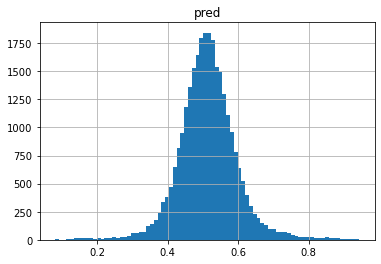

In [18]:
preds = []
for i in range(K):
    model = models[i]
    pred = model.predict(test_X, prediction_type='Probability')[:,1]
    preds.append(pred)
    print(np.sum(pred) / pred.shape[0])
    
preds = np.array(preds)
preds = np.mean(preds, axis=0)
print(np.sum(preds) / preds.shape[0])


temp = pd.DataFrame({"pred":pred})
temp.hist(bins=80)

In [19]:
preds_ = np.where(preds < THRESHOLD, 0, 1)
print(np.sum(preds_) / preds_.shape[0])

submit_df = pd.DataFrame({'y': preds_})
submit_df.index.name = 'id'
submit_df.to_csv('../Submissions/submission_cat_6_psd1_{}.csv'.format(K))

0.5763585038814396


# Pseudo Labeling

In [20]:
test_X["pred"] = preds
test_X["y"] = preds_
ps_X = pd.concat([X, test_X[np.abs(0.5-test_X["pred"]) > 0.20]])
ps_y = np.append(y, test_X["y"][np.abs(0.5-test_X["pred"]) > 0.20].values)



test_X.drop(columns=["pred"], inplace=True)
test_X.drop(columns=["y"], inplace=True)
ps_X.drop(columns=["pred"], inplace=True)
ps_X.drop(columns=["y"], inplace=True)

In [21]:
# 全データを5つに分割
SIZE = ps_X.shape[0]
K = 10


#folds = prepro.make_stratified_kfolds(X, y, K, shuffle=True)
folds = prepro.make_stratified_kfolds(ps_X, ps_X["mode"].astype(str) + ps_y.astype(str), K, shuffle=True, random_state=random.randint(0, 10000))


print(len(folds))
for i, fold in enumerate(folds):
    print("fold ", i+1, " size is ", len(fold))
    
    
if SIZE != len(set(sum(folds, []))):
    print("error is occuring in spliting")
else :
    print("successfully split")


10
fold  1  size is  13308
fold  2  size is  13308
fold  3  size is  13308
fold  4  size is  13308
fold  5  size is  13308
fold  6  size is  13308
fold  7  size is  13308
fold  8  size is  13308
fold  9  size is  13307
fold  10  size is  13307
successfully split


In [22]:
params = {
    "loss_function" : "Logloss",
    "eval_metric" : "Logloss",
    "iterations":2000,
    "learning_rate" : 0.05,
    "use_best_model": True,
    "random_seed":random.randint(0, 100000),

    

}

THRESHOLD = 0.50
models = []
cv_scores = []
temp = 0
train_pred = []
valid_ys = []

all_indices = sum(folds, [])
for i in range(K):
    print("======================== fold {} ========================".format(i+1))
    valid_indices = folds[i]
    train_indices = list(set(all_indices) - set(valid_indices))
    # print("train ", len(train_indices), " , valid ", len(valid_indices))
    

    train_X = ps_X.iloc[train_indices]
    try:
        train_y = ps_y.iloc[train_indices]
    except:
        train_y = ps_y[train_indices]
    valid_X = ps_X.iloc[valid_indices]
    try:
        valid_y = ps_y.iloc[valid_indices]
    except:
        valid_y = ps_y[valid_indices]
    
    
    
    
    train_data = Pool(train_X, train_y, cat_features=categorical_features_indices)
    valid_data = Pool(valid_X, valid_y, cat_features=categorical_features_indices)
    
    model = CatBoostClassifier(**params)

    
    model.fit(
        train_data,
        eval_set=valid_data,
        early_stopping_rounds=50,
        verbose=100,
        use_best_model=True,
    )
    
    pred = model.predict(valid_X, prediction_type='Probability')[:,1]
    train_pred.append(pred)
    pred = np.where(pred < THRESHOLD, 0, 1)

    temp += np.sum(pred) 
    
    score = accuracy_score(pred, valid_y)
    
    models.append(model)
    cv_scores.append(score)
    
    
print("cv score : ", np.mean(cv_scores))    
print("cv ratio : ", temp / SIZE)

======================== fold 1 ========================
0:	learn: 0.6926274	test: 0.6926997	best: 0.6926997 (0)	total: 893ms	remaining: 29m 44s
100:	learn: 0.6785761	test: 0.6818443	best: 0.6818432 (99)	total: 1m 45s	remaining: 32m 59s
200:	learn: 0.6723914	test: 0.6779587	best: 0.6779587 (200)	total: 3m 36s	remaining: 32m 16s
300:	learn: 0.6662260	test: 0.6750118	best: 0.6750118 (300)	total: 5m 22s	remaining: 30m 19s
400:	learn: 0.6607980	test: 0.6731340	best: 0.6731093 (388)	total: 7m 12s	remaining: 28m 44s
500:	learn: 0.6561680	test: 0.6720453	best: 0.6720453 (500)	total: 9m 4s	remaining: 27m 8s
600:	learn: 0.6518741	test: 0.6709207	best: 0.6709115 (596)	total: 11m	remaining: 25m 37s
700:	learn: 0.6478572	test: 0.6701363	best: 0.6701199 (691)	total: 12m 53s	remaining: 23m 53s
800:	learn: 0.6440582	test: 0.6697215	best: 0.6696878 (787)	total: 14m 44s	remaining: 22m 4s
900:	learn: 0.6397952	test: 0.6681354	best: 0.6681289 (890)	total: 16m 42s	remaining: 20m 23s
1000:	learn: 0.6360049

Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.666718227
bestIteration = 1142

Shrink model to first 1143 iterations.
======================== fold 8 ========================
0:	learn: 0.6927070	test: 0.6927930	best: 0.6927930 (0)	total: 1.26s	remaining: 41m 54s
100:	learn: 0.6784285	test: 0.6821195	best: 0.6821195 (100)	total: 2m 7s	remaining: 39m 48s
200:	learn: 0.6720232	test: 0.6778839	best: 0.6778689 (199)	total: 4m 18s	remaining: 38m 37s
300:	learn: 0.6657738	test: 0.6735224	best: 0.6735064 (299)	total: 6m 32s	remaining: 36m 54s
400:	learn: 0.6603335	test: 0.6715455	best: 0.6715455 (400)	total: 8m 42s	remaining: 34m 44s
500:	learn: 0.6555805	test: 0.6701605	best: 0.6701125 (497)	total: 10m 53s	remaining: 32m 36s
600:	learn: 0.6513788	test: 0.6693347	best: 0.6693172 (590)	total: 13m 4s	remaining: 30m 26s
700:	learn: 0.6472711	test: 0.6687756	best: 0.6687373 (694)	total: 15m 19s	remaining: 28m 22s
800:	learn: 0.6429484	test: 0.6678033	best: 0.6677629 (794)	tota

0.5175793983514205
0.5158227946318781
0.5145723691772472
0.5166224927183904
0.5164842556082632
0.5176016906983253
0.5156272570266398
0.5172387933880456
0.5146761218974872
0.5174854157676054
0.5163710589265302


array([[<AxesSubplot:title={'center':'pred'}>]], dtype=object)

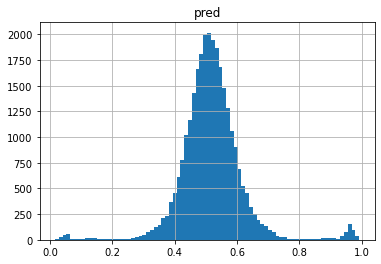

In [23]:
preds = []
for i in range(K):
    model = models[i]
    pred = model.predict(test_X, prediction_type='Probability')[:,1]
    preds.append(pred)
    print(np.sum(pred) / pred.shape[0])
    
preds = np.array(preds)
preds = np.mean(preds, axis=0)
print(np.sum(preds) / preds.shape[0])


temp = pd.DataFrame({"pred":pred})
temp.hist(bins=80)

In [24]:
preds_ = np.where(preds < THRESHOLD, 0, 1)
print(np.sum(preds_) / preds_.shape[0])

submit_df = pd.DataFrame({'y': preds_})
submit_df.index.name = 'id'
submit_df.to_csv('../Submissions/submission_cat_6_psd2_{}.csv'.format(K))

0.5800282286520818


# Pseudo Labeling2

In [25]:
test_X["pred"] = preds
test_X["y"] = preds_
ps_X = pd.concat([X, test_X[np.abs(0.5-test_X["pred"]) > 0.25]])
ps_y = np.append(y, test_X["y"][np.abs(0.5-test_X["pred"]) > 0.25].values)



test_X.drop(columns=["pred"], inplace=True)
test_X.drop(columns=["y"], inplace=True)
ps_X.drop(columns=["pred"], inplace=True)
ps_X.drop(columns=["y"], inplace=True)

In [26]:
# 全データを5つに分割
SIZE = ps_X.shape[0]
K = 10


#folds = prepro.make_stratified_kfolds(X, y, K, shuffle=True)
folds = prepro.make_stratified_kfolds(ps_X, ps_X["mode"].astype(str) + ps_y.astype(str), K, shuffle=True, random_state=random.randint(0, 10000))


print(len(folds))
for i, fold in enumerate(folds):
    print("fold ", i+1, " size is ", len(fold))
    
    
if SIZE != len(set(sum(folds, []))):
    print("error is occuring in spliting")
else :
    print("successfully split")


10
fold  1  size is  13308
fold  2  size is  13308
fold  3  size is  13308
fold  4  size is  13308
fold  5  size is  13308
fold  6  size is  13308
fold  7  size is  13308
fold  8  size is  13308
fold  9  size is  13307
fold  10  size is  13307
successfully split


In [ ]:
params = {
    "loss_function" : "Logloss",
    "eval_metric" : "Logloss",
    "iterations":2000,
    "learning_rate" : 0.05,
    "use_best_model": True,
    "random_seed":random.randint(0, 100000),

    

}

THRESHOLD = 0.50
models = []
cv_scores = []
temp = 0
train_pred = []
valid_ys = []

all_indices = sum(folds, [])
for i in range(K):
    print("======================== fold {} ========================".format(i+1))
    valid_indices = folds[i]
    train_indices = list(set(all_indices) - set(valid_indices))
    # print("train ", len(train_indices), " , valid ", len(valid_indices))
    

    train_X = ps_X.iloc[train_indices]
    try:
        train_y = ps_y.iloc[train_indices]
    except:
        train_y = ps_y[train_indices]
    valid_X = ps_X.iloc[valid_indices]
    try:
        valid_y = ps_y.iloc[valid_indices]
    except:
        valid_y = ps_y[valid_indices]
    
    
    
    
    train_data = Pool(train_X, train_y, cat_features=categorical_features_indices)
    valid_data = Pool(valid_X, valid_y, cat_features=categorical_features_indices)
    
    model = CatBoostClassifier(**params)

    
    model.fit(
        train_data,
        eval_set=valid_data,
        early_stopping_rounds=50,
        verbose=100,
        use_best_model=True,
    )
    
    pred = model.predict(valid_X, prediction_type='Probability')[:,1]
    train_pred.append(pred)
    pred = np.where(pred < THRESHOLD, 0, 1)

    temp += np.sum(pred) 
    
    score = accuracy_score(pred, valid_y)
    
    models.append(model)
    cv_scores.append(score)
    
    
print("cv score : ", np.mean(cv_scores))    
print("cv ratio : ", temp / SIZE)

======================== fold 1 ========================
0:	learn: 0.6926450	test: 0.6927380	best: 0.6927380 (0)	total: 866ms	remaining: 28m 51s
100:	learn: 0.6783925	test: 0.6806959	best: 0.6806959 (100)	total: 1m 48s	remaining: 33m 56s
200:	learn: 0.6724233	test: 0.6771231	best: 0.6771198 (199)	total: 3m 42s	remaining: 33m 11s
300:	learn: 0.6664587	test: 0.6749420	best: 0.6749420 (300)	total: 5m 29s	remaining: 31m 2s
400:	learn: 0.6609682	test: 0.6722059	best: 0.6722017 (394)	total: 7m 25s	remaining: 29m 38s
500:	learn: 0.6561825	test: 0.6704370	best: 0.6703707 (481)	total: 9m 24s	remaining: 28m 8s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6703706705
bestIteration = 481

Shrink model to first 482 iterations.
======================== fold 2 ========================
0:	learn: 0.6926104	test: 0.6926342	best: 0.6926342 (0)	total: 1.02s	remaining: 34m
100:	learn: 0.6784744	test: 0.6827743	best: 0.6827743 (100)	total: 1m 47s	remaining: 33m 41s
200:	learn: 0.671955

In [ ]:
preds = []
for i in range(K):
    model = models[i]
    pred = model.predict(test_X, prediction_type='Probability')[:,1]
    preds.append(pred)
    print(np.sum(pred) / pred.shape[0])
    
preds = np.array(preds)
preds = np.mean(preds, axis=0)
print(np.sum(preds) / preds.shape[0])


temp = pd.DataFrame({"pred":pred})
temp.hist(bins=80)

In [ ]:
preds_ = np.where(preds < THRESHOLD, 0, 1)
print(np.sum(preds_) / preds_.shape[0])

submit_df = pd.DataFrame({'y': preds_})
submit_df.index.name = 'id'
submit_df.to_csv('../Submissions/submission_cat_6_psd3_{}.csv'.format(K))

# モデル解釈

In [ ]:
importance = pd.DataFrame(
    (models[0].get_feature_importance() + 
    models[1].get_feature_importance() + 
    models[2].get_feature_importance() + 
    models[3].get_feature_importance() + 
    models[4].get_feature_importance())/5
    , index=X.columns, columns=['importance']).sort_values('importance', ascending=False)
display(importance[:120])

In [ ]:
indices = [index for index in importance.index if "team" in index]
importance.loc[indices]

In [ ]:
train_pred

In [ ]:
train_df[train_df["disconnection-A"] != 0][["disconnection-A", "disconnection-B", "y", "pred"]]

In [ ]:
train_df["pred"] = 0
train_df["y"] = y
for i in range(K):
    train_df["pred"].iloc[folds[i]] = np.where(train_pred[i] < THRESHOLD, 0, 1)
    #train_df["pred"].iloc[folds[i]] = train_pred[i]
for mode in train_df["mode"].unique():
    rate = train_df[train_df["mode"] == mode][train_df["pred"] == train_df["y"]].shape[0] / train_df[train_df["mode"] == mode].shape[0]
    print("{} : {}".format(mode, rate))
print(train_df[train_df["pred"] == train_df["y"]].shape[0] / train_df.shape[0])

In [ ]:
result_df = train_df[train_df["y"] != train_df["pred"]]

In [ ]:
print(result_df[result_df["mode"] == "nawabari"].shape[0]/result_df.shape[0])
print(result_df[result_df["mode"] == "hoko"].shape[0]/result_df.shape[0])
print(result_df[result_df["mode"] == "asari"].shape[0]/result_df.shape[0])
print(result_df[result_df["mode"] == "area"].shape[0]/result_df.shape[0])
print(result_df[result_df["mode"] == "yagura"].shape[0]/result_df.shape[0])

In [ ]:
result_df[result_df["mode"] == "nawabari"]

In [ ]:
preds

In [ ]:
def plot_feature_importance(importance,names,model_type, MAXSIZE=120):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)[:MAXSIZE]
    feature_names = np.array(names)[:MAXSIZE]

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(20,16))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

In [ ]:
plot_feature_importance(importance.values.reshape(-1,), importance.index, "Cat Boost ", MAXSIZE=40)

In [ ]:
train_df

In [ ]:
v = train_df["team-subweapon-A"].value_counts().add(
    train_df["team-subweapon-B"].value_counts().add(
        test_df["team-subweapon-A"].value_counts().add(
            test_df["team-subweapon-A"].value_counts(), fill_value=0
        ), fill_value=0
    ), fill_value=0
).sort_values(ascending=False)

In [ ]:
x = np.arange(len(v))
plt.bar(x, v)
plt.show()

In [ ]:
def find_rare(df1, df2, col, threshold=4):
    v_tra = df1[col + "-A"].value_counts()
    v_trb = df1[col + "-B"].value_counts()
    v_tea = df2[col + "-A"].value_counts()
    v_teb = df2[col + "-B"].value_counts()
    
    v_counts = v_tra.add(v_trb, fill_value=0)
    v_counts = v_counts.add(v_tea, fill_value=0)
    v_counts = v_counts.add(v_teb, fill_value=0)
    
    #threshold = v_counts.iloc[int(v_counts.shape[0]*0.8)]

    tra = df1[col + "-A"].unique()
    trb = df1[col + "-B"].unique()
    tea = df2[col + "-A"].unique()
    teb = df2[col + "-B"].unique()

    not_appeared = []
    print("fin count")
    for item in v_counts.index:
        if item not in tra or item not in trb or item not in tea or item not in teb or v_tra.loc[item] < 5 or v_trb.loc[item] < 5:
            not_appeared.append(item)

    print("fin find rare", len(not_appeared))
    df1[col + "-A"] = df1[col + "-A"].map(lambda x: "rare" if x in not_appeared else x)
    df1[col + "-B"] = df1[col + "-B"].map(lambda x: "rare" if x in not_appeared else x)
    df2[col + "-A"] = df2[col + "-A"].map(lambda x: "rare" if x in not_appeared else x)
    df2[col + "-B"] = df2[col + "-B"].map(lambda x: "rare" if x in not_appeared else x)

    return df1, df2

In [ ]:
train_df, test_df = find_rare(train_df, test_df, "team-special") #473 sub

In [ ]:
test_df["team-special-A"].value_counts().sort_values(ascending=False)